Percentage area with BII >= 0.75 in 2017: 79.65857812266721%
Percentage area with BII >= 0.75 in 2020: 79.4755090425761%


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x76f608257010>

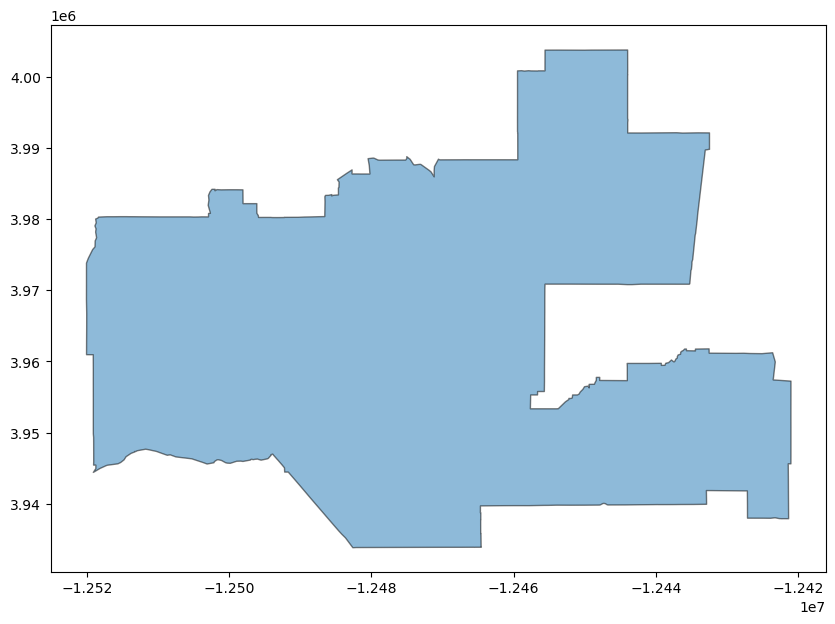

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import rioxarray
import pystac_client
import planetary_computer as pc

# Download Phoenix subdivision shapefile
phoenix_shape_url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_04_cousub_500k.zip"
phoenix_shapes = gpd.read_file(phoenix_shape_url)

# Filter for the Phoenix subdivision
phoenix_subdivision = phoenix_shapes[phoenix_shapes['NAME'] == 'Phoenix']

# Access BII data for 2017 and 2020
bii_collection = "io-biodiversity"
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Initialize STAC client
client = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Search for BII assets
search_2017 = client.search(collections=[bii_collection], bbox=bbox, datetime="2017-01-01/2017-12-31")
search_2020 = client.search(collections=[bii_collection], bbox=bbox, datetime="2020-01-01/2020-12-31")

# Get the first item from the search results
item_2017 = next(search_2017.items())
item_2020 = next(search_2020.items())

# Sign the asset to get the href
href_2017 = pc.sign(item_2017.assets["data"].href)
href_2020 = pc.sign(item_2020.assets["data"].href)

# Load BII raster data
bii_raster_2017 = rioxarray.open_rasterio(href_2017, masked=True).squeeze()
bii_raster_2020 = rioxarray.open_rasterio(href_2020, masked=True).squeeze()


# Calculate the percentage of area with BII >= 0.75 for 2017
bii_high_2017 = (bii_raster_2017 > 0.75).astype(int)
percentage_2017 = bii_high_2017.sum().item() / bii_raster_2017.size * 100

# Calculate the percentage of area with BII >= 0.75 for 2020
bii_high_2020 = (bii_raster_2020 > 0.75).astype(int)
percentage_2020 = bii_high_2020.sum().item() / bii_raster_2020.size * 100

print(f"Percentage area with BII >= 0.75 in 2017: {percentage_2017}%")
print(f"Percentage area with BII >= 0.75 in 2020: {percentage_2020}%")

# Create a map showing the Phoenix subdivision
ax = phoenix_subdivision.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)
plt.show()

# Visualization of Area Lost by 2020
bii_loss = (bii_raster_2017 > 0.75) & (bii_raster_2020 < 0.75)
bii_loss.astype(int).plot()
plt.title("Area with BII >= 0.75 in 2017 Lost by 2020")
plt.show()
